In [89]:
from collections import deque

import numpy as np
import polars as pl
import seaborn as sns

import matplotlib.pyplot as plt
from src.config import DirectoryPaths
from src.matplotlib import Styles

plt.style.use(Styles.CMR10.value)

# Load the data

In [90]:
def load_data() -> pl.DataFrame:
    """Load the dataset from a CSV file and preprocess it.

    Returns:
        pl.DataFrame: Preprocessed dataset with 'Date' and 'Earnings Per Share' columns.
    """
    return (
        pl.read_csv(
            DirectoryPaths.EXTERNAL_DATA.value / "jj.csv",
            schema={"date": pl.Date, "value": pl.Float64},
        )
        .with_columns(
            [pl.col("date").alias("Date"), pl.col("value").alias("Earnings Per Share")]
        )
        .select(["Date", "Earnings Per Share"])
    )


dataset = load_data()
dataset

Date,Earnings Per Share
date,f64
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61
…,…
1979-10-01,9.99
1980-01-01,16.2
1980-04-01,14.67


## Splitting the data set

In [ ]:
def split_data(ratio: float, data: pl.Series) -> tuple[pl.Series, pl.Series]:
    """Split the dataset into training and testing sets based on the given ratio.

    Args:
        ratio (float): The ratio of the training set size to the total dataset size.
        data (pl.Series): The dataset to be split.

    Returns:
        tuple[pl.Series, pl.Series]: A tuple containing the training and testing sets.
    """
    dataset_size = data.len()
    train_size = int(ratio * dataset_size)
                # drop the first element
    train, test = data[1:train_size], data[train_size:]
    return train, test

train, test = split_data(0.8, dataset["Earnings Per Share"])

# Rolling Forecasting Method

In [166]:
from statsmodels.tsa.ar_model import AutoReg

WINDOW_SIZE = 12

autoreg = AutoReg(train.to_list(), lags=WINDOW_SIZE)
autoreg_fit = autoreg.fit()
predictions = autoreg_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
predictions_series = pl.Series(predictions)

Text(0, 0.5, 'Earnings Per Share')

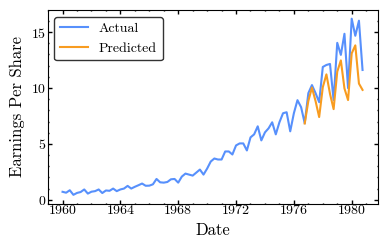

In [167]:
sns.lineplot(x=dataset["Date"], y=dataset["Earnings Per Share"], label="Actual")
sns.lineplot(x=dataset["Date"][-len(test):], y=predictions_series, label="Predicted")
plt.xlabel("Date")
plt.ylabel("Earnings Per Share")

In [168]:
from typing import Union


class RollingForecaster:
    """
    Rolling linear forecaster using fixed coefficients.

    This class maintains a sliding window of recent time series values
    and computes 1-step-ahead forecasts using a dot product of the
    stored data and precomputed coefficients plus a bias term.

    Parameters
    ----------
    coefficients : list or numpy.ndarray
        Coefficients for the forecast model, ordered from oldest lag
        to the most recent (e.g., ``[coef(t-2), coef(t-1), coef(t)]``).

    data : list, numpy.ndarray, or polars.Series
        Initial window of past observations, ordered from oldest to most
        recent (e.g., ``[x(t-2), x(t-1), x(t)]``). The length must match
        the number of coefficients.
    
    bias : int, optional
        Intercept term added to the dot product, by default 0.

    Notes
    -----
    - If `data` is shorter than the number of `coefficients`, calling
      ``forecast()`` will raise an error.
    - Internally, data is stored in a deque with a fixed maximum length
      equal to the number of coefficients.
    """

    def __init__(
        self,
        coefficients: Union[list, np.ndarray],
        data: Union[list, np.ndarray, pl.Series],
        bias: int = 0
    ):
        """
        Initialize the rolling forecaster.

        Parameters
        ----------
        coefficients : list or numpy.ndarray
            Coefficients for the forecast model, ordered from oldest lag
            to the most recent (e.g., ``[coef(t-2), coef(t-1), coef(t)]``).
        data : list, numpy.ndarray, or polars.Series
            Initial window of past observations, ordered from oldest to most
            recent (e.g., ``[x(t-2), x(t-1), x(t)]``). The length must match
            the number of coefficients.
        bias : int, optional
            Intercept term added to the dot product, by default 0.

        Notes
        -----
        Given time step ``t`` and the next forecast (to predict) step ``t+1``:

        The forecast is computed as:

        ``forecast(t+1) = dot(coefficients, data) + bias``

        where:
            - ``data`` is the rolling window of observations ``[x(t-lag), ..., x(t)]``
            - ``coefficients`` are aligned in the same order
            - ``bias`` is the intercept term

        Example
        -------
        If::

            data = [x(t-2), x(t-1), x(t)]
            coefficients = [coef(t-2), coef(t-1), coef(t)]

        then::

            forecast(t+1) = coef(t-2)*x(t-2) + coef(t-1)*x(t-1) + coef(t)*x(t) + bias
        """
        if isinstance(data, list):
            data = np.array(data, dtype=float)
        elif isinstance(data, pl.Series):
            data = data.to_numpy()

        if isinstance(coefficients, list):
            coefficients = np.array(coefficients)

        self.window_size = len(coefficients)
        self.data = deque(data, maxlen=self.window_size)
        self.coefficients = coefficients
        self.bias = bias

    def update_data(self, latest_value: float):
        """
        Append a new observation to the rolling window.

        Parameters
        ----------
        latest_value : float
            The most recent time series value x(t+1).
        """
        self.data.append(latest_value)

    def forecast(self) -> float:
        """
        Compute the forecast using the current window.

        Returns
        -------
        float
            The 1-step-ahead forecast value:
            ``dot(coefficients, data_window) + bias``.

        Raises
        ------
        ValueError
            If the rolling window does not yet contain enough values
            to match the number of coefficients.
        """
        if len(self.data) != self.window_size:
            raise ValueError(
                f"Not enough data to make a forecast. "
                f"Coefficients length: {self.window_size}, "
                f"Data length: {len(self.data)}")
        
        return float(np.dot(self.coefficients, self.data) + self.bias)
    
    __next__ = forecast

In [169]:
coefs = autoreg_fit.params[1:]
bias = autoreg_fit.params[0]

forecaster = RollingForecaster(
    coefficients=coefs[::-1], 
    data=train[-len(coefs):], 
    bias=bias
    )

predictions = []
for actual in test:
    prediction = forecaster.forecast()
    predictions.append(prediction)
    forecaster.update_data(actual)

for quarter in range(4):
    prediction = forecaster.forecast()
    predictions.append(prediction)
    forecaster.update_data(prediction)


predictions_series = pl.Series(predictions)
predictions_series

""
f64
6.82333
8.851993
10.285858
8.945962
7.720722
…
11.789376
18.087933
17.265105


Text(0.5, 1.0, 'Rolling Forecast vs Actual Observations')

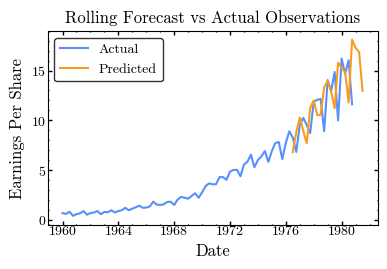

In [170]:
new_dates = pl.date_range(
    start=dataset["Date"][len(train)],
    end=dataset["Date"][-1] + pl.duration(days=90 * 4),
    interval="3mo",
    eager=True
)

sns.lineplot(x=dataset["Date"], y=dataset["Earnings Per Share"], label="Actual")
sns.lineplot(x=new_dates, y=predictions_series, label="Predicted")
plt.xlabel("Date")
plt.ylabel("Earnings Per Share")
plt.title("Rolling Forecast vs Actual Observations")

In [136]:
test_array = [2 ,3 ,4]


test_array[-2:]

[3, 4]